In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from qiskit import QuantumCircuit, Aer
from qiskit.utils import QuantumInstance
from qiskit import transpile 

from vqa_poisson import VQAforPoisson

## Experiments

In [2]:
def create_initial_state(N):
    x = np.linspace(0,1,N)
    y = np.cos(x)
    y = y / np.linalg.norm(y)
    
    return y

def experiment(bc, num_trials, num_qubits_list, num_layers, qins, optimze=False):
    
    print('-----------'+bc+' boundary condition --------------')
    
    data = {'num_qubits':[], 'obj_count':[], 'circ_count':[], 'iter_count':[], 'err':[], 'params':[], 'q_sol':[], 'cl_sol':[]}
    
    for num_qubits in tqdm(num_qubits_list):
        print('-------------------------')
        print('num_qubits:', num_qubits)
        
        # set oracle for f vector
        oracle_f = QuantumCircuit(num_qubits)
        oracle_f.x(num_qubits-1)
        oracle_f.h(oracle_f.qubits)

        # change oracle to cosine function
        # y = create_initial_state(2**num_qubits)
        # init_f = QuantumCircuit(num_qubits)
        # init_f.initialize(y, range(0,num_qubits))

        # Transpile the composed circuit for execution
        # oracle_f = transpile(init_f, optimization_level=3)

    
        # set vqa instance
        vqa = VQAforPoisson(num_qubits, num_layers, bc, oracle_f=oracle_f, qinstance=qins, optimize_shift=optimze)


        obj_counts = []
        circ_counts = []
        iter_counts = []
        err = []
        params = []
        q_sol = []
    
        for seed in range(num_trials):
        
            np.random.seed(seed)
            x0 = list(4*np.pi*np.random.rand(vqa.num_params))
            print(x0)
            #vqa.print_matrix(x0)
            
            res = vqa.minimize(x0, method='bfgs', save_logs=True)
            
    
            obj_counts.append(vqa.objective_counts)
            circ_counts.append(vqa.circuit_counts)
            iter_counts.append(len(vqa.objective_count_logs))
            err.append(vqa.get_errors(res['x'])['trace'])
            params.append(res['x'])
            q_sol.append(vqa.get_sol(res['x']).real)
            vqa.print_matrix(res['x'])
            
            print('trial:', seed, 'Err.:', err[-1])
        
        data['num_qubits'].append(num_qubits)
        data['obj_count'].append(obj_counts)
        data['circ_count'].append(circ_counts)
        data['iter_count'].append(iter_counts)
        data['err'].append(err)
        data['params'].append(params)
        data['q_sol'].append(q_sol)
        data['cl_sol'].append(vqa.get_cl_sol().real)
        
    return data

In [3]:
t0 = time.time()
# optimizer = 'spsa'
num_layers = 5
num_trials = 1
num_qubits_list = [4]
optimize_shift=False
qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)

# bc: Periodic
data_p = experiment('Periodic', num_trials, num_qubits_list, num_layers, qins, optimze=optimize_shift)

C:\Users\jlvmi\AppData\Local\Temp\ipykernel_22644\1966141857.py:7: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qins = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=42)


-----------Periodic boundary condition --------------


  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------
num_qubits: 4
[6.896593888515826, 8.987334637284528, 7.574547976478632, 6.847204019070697, 5.323803221044644, 8.116544802428407, 5.498883072830878, 11.206350031706826, 12.109743395712375, 4.8184682344975025, 9.949110253214393, 6.646289577666751, 7.1382584801773445, 11.63139039619053, 0.8926654342978345, 1.0948990714191347, 0.2540718754635438, 10.463009560025881, 9.77860612850141, 10.932895093864325, 12.297680778506693, 10.042522697586502, 5.799120696948454, 9.808418904536085, 1.4862802696695647, 8.041484717920905, 1.8014305383688254, 11.871059719510393, 6.557739415592751, 5.210795617590082, 3.324503869815388, 9.729307483553026, 5.73215413049621, 7.143151671267129]
-0.008803612424205558
-0.01318966921622542
-0.040689452026620804
-0.34124678325147995
-0.0005495543276814123
-0.4332231008790518
-0.5196313002575765
-0.5358545820659424
It.: 00001, Obj.: -5.358546e-01
-0.0010512173136872276
-0.0013988014901138164
-0.5306733204727824
-0.5371640360392568
It.: 00002, Ob

C:\Users\jlvmi\AppData\Local\Temp\ipykernel_22644\2677146210.py:58: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  q_sol.append(vqa.get_sol(res['x']).real)


## plots

### distribution of solutions

In [5]:
def global2grid(cl_sol):
    N = len(cl_sol)
    n = int(np.sqrt(N))
    F = np.zeros((n,n))

    for i in range(N):
        xi = int(np.floor(i/n))
        yi = int(i % n)
        F[xi,yi] = cl_sol[i]

    return F

def plot_solution_vectors(q_sol, cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(q_sol, label='quantum', color='blue')
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(q_sol)
    qnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.65, 'Norm (quantum) = %.1f'%(qnorm), transform=ax.transAxes)
    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)

    # Save the figure as a PDF
    fig.savefig('solution_vectors.pdf', format='pdf')
    
    return fig, ax

def plot_solution_vectors_2D(q_sol, cl_sol, N):
    
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)

    x, y = np.meshgrid(x, y) 
  
    F = global2grid(q_sol)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, F) 
    
    return fig, ax

In [6]:
idx1, idx2 = 0, 0

Periodic boundary condition, num_qubits: 4
[ 0.05638238  0.01770524  0.00017523 -0.00452912  0.00421689 -0.02498006
 -0.04785248  0.01379468 -0.01359331  0.01400418  0.01185607 -0.03057324
  0.00100009 -0.01451117 -0.04254998  0.01885122]


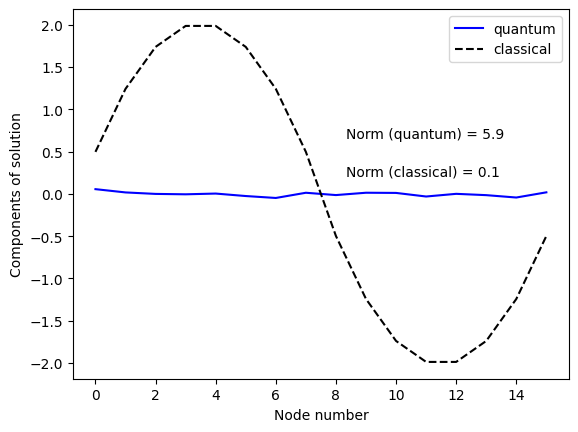

In [7]:
print('Periodic boundary condition, num_qubits:', data_p['num_qubits'][idx1])
q_sol = data_p['q_sol'][idx1][idx2]
cl_sol = data_p['cl_sol'][idx1]
plot_solution_vectors(q_sol, cl_sol)
# plot_solution_vectors_2D(q_sol, cl_sol, 1)
print(q_sol)

In [8]:
print('elapsed time: %.2e'%(time.time() - t0))

elapsed time: 5.50e+02


In [11]:
oracle_f = QuantumCircuit(4)
oracle_f.x(4-1)
oracle_f.h(oracle_f.qubits)
oracle_f.draw(fold=-1)

┌───┐     
q_0: ┤ H ├─────
     ├───┤     
q_1: ┤ H ├─────
     ├───┤     
q_2: ┤ H ├─────
     ├───┤┌───┐
q_3: ┤ X ├┤ H ├
     └───┘└───┘

In [57]:
from qiskit import execute, Aer

f_vec = np.array(execute(oracle_f, Aer.get_backend('statevector_simulator')).result().get_statevector())

In [64]:
def get_A_matrix():
    num_qubits = 4

    I0 = np.array([[1, 0], [0, 0]])
    I = np.array([[1, 0], [0, 1]])
    X = np.array([[0, 1], [1, 0]])

    P = np.zeros((2**num_qubits, 2**num_qubits))
    for i in range(2**num_qubits):
        P[(i+1)%(2**num_qubits), i] = 1

    A0 = I - X
    for i in range(num_qubits-1):
        A0 = np.kron(I, A0)
    A1 = P.T @ A0 @ P

    A = A0 + A1 + (1e-3)*np.eye(2**num_qubits)

    return A

In [65]:
print(np.asmatrix(get_A_matrix()))
print(np.array(f_vec).real)
import scipy

Ainv = np.linalg.inv(get_A_matrix())
s1 = Ainv @ f_vec.real
s2 = scipy.linalg.solve(get_A_matrix(), f_vec.real)
print(s1)
print(s2)

[[ 2.001 -1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.    -1.   ]
 [-1.     2.001 -1.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.    -1.     2.001 -1.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -1.     2.001 -1.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -1.     2.001 -1.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -1.     2.001 -1.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -1.     2.001 -1.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -1.     2.001 -1.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -1.     2.001 -1.
   0.     0.     0.

In [138]:
def plot_solution(cl_sol):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cl_sol, label='classical', color='black', linestyle='dashed')
    ax.legend()
    ax.set_xlabel('Node number')
    ax.set_ylabel('Components of solution')

    cnorm = np.linalg.norm(cl_sol)

    ax.text(0.55, 0.55, 'Norm (classical) = %.1f'%(cnorm), transform=ax.transAxes)
    
    return fig, ax

plot_solution(s1)

NameError: name 's1' is not defined

In [139]:
plot_solution(s2)

NameError: name 's2' is not defined